## Setup

### Download required weights

In [1]:
## Download mask rcnn 
## Download depth map 
## !wget -q http://www.cs.cornell.edu/projects/megadepth/dataset/models/best_generalization_net_G.pth 
## !mv best_generalization_net_G.pth ./pretrain/depthmap.pth
## Download PyNet
## !wget -q http://yucanwu.com/share/pynet_bokeh_level_0.zip

!pwd

/home/ubuntu/capstone-pixelart/app/backend


## Load weights and build models

In [2]:
from libpixelartbokeh.ObjectDetection import ObejctDetection
from libpixelartbokeh.MegaDepthMap import MegaDepthMap
from libpixelartbokeh.PyNet import PyNet

objectDetectioModel = ObejctDetection(checkpoint_path="./pretrain/pretrain_maskrcnn.pt")
megaDepthMapModel = MegaDepthMap(checkpoint_path="./pretrain/depthmap.pth")
pyNet = PyNet(checkpoint_path="./pretrain/PyNET/aws_epoch_1000")
# pyNet = PyNet(checkpoint_path="./pretrain/PyNET/best.ckpt")
# pyNet = PyNet(checkpoint_path="./pretrain/PyNET/pynet_bokeh_level_0")

Instructions for updating:
non-resource variables are not supported in the long term
===========================================LOADING Hourglass NETWORK====================================================
model [HGModel] was created


## Test Models

In [37]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import traceback
import timeit

samples_path = Path("./res/samples")
results_path = Path("./res/results")
mask_results = []
depth_results = []
bokeh_results = []

for sample in samples_path.iterdir():
    if sample.is_file():
        # Load image
        s_time = timeit.default_timer()
        try:
            img = Image.open(sample).convert("RGB")
            ratio = np.min((2560 / img.size[0], 1440 / img.size[1]))
            new_shape = np.array((img.size[0] * ratio, img.size[1] * ratio)).astype(np.uint32)
            img = img.resize(new_shape, Image.ANTIALIAS) 
            img = np.array(img)
            print(f"Loaded image {str(sample)} with shape {img.size} new_shape {img.shape}", end="\t")
        except Exception as e:
            print(e)
            traceback.print_exc()
        print(f"Time spent: {timeit.default_timer() - s_time:7.3f}s")
            
        s_time = timeit.default_timer()
        # mask generation
        mask = None
        try:
            mask_results.append(objectDetectioModel.predict(img))
            mask = mask_results[-1][0]
            print(f"Gnerated mask shape {mask.shape}", end="\t")
        except Exception as e:
            print(e)
            traceback.print_exc()
        print(f"Time spent: {timeit.default_timer() - s_time:7.3f}s")
        break
        s_time = timeit.default_timer()
        # depth generation
        depthmap = None
        try:
            depth_results.append(megaDepthMapModel.predict(img))
            depthmap = depth_results[-1]
            print(f"Gnerated depth map shape {depthmap.shape}", end="\t")
        except Exception as e:
            print(e)
            traceback.print_exc()
        print(f"Time spent: {timeit.default_timer() - s_time:7.3f}s")
        
        s_time = timeit.default_timer()
        # bokeh/blur generation
        try:
            best_mask = depthmap
            best_confidence = -1
            if mask is not None:
                for mask, confidence in zip(*mask_results[-1]):
                    if best_confidence < confidence:
                        best_mask = mask[0]
                        best_confidence = confidence
            print(f"Found best mask with confidence {best_confidence} shape {best_mask.shape}")
            bokeh_results.append(pyNet.predict(img, mask=best_mask))
            bokeh_img = bokeh_results[-1]
            print(f"Gnerated bokeh image shape {bokeh_img.shape}", end="\t")
        except Exception as e:
            print(e)
            traceback.print_exc()
        print(f"Time spent: {timeit.default_timer() - s_time:7.3f}s")
        
        Image.fromarray((bokeh_img[0] * 255.).astype(np.uint8)).save(f"./res/results/{sample.stem}_bokeh_aws.png")


Loaded image res/samples/breakreate-tFA3kJcMUco-unsplash.jpg with shape 4432320 new_shape (1440, 1026, 3)	Time spent:   0.321s
Gnerated mask shape (2, 1, 1440, 1026)	Time spent:   2.970s


In [40]:
img = mask[0][0]
# buffered = io.BytesIO()
im = Image.fromarray(img)
if im.mode != 'RGB':
    im = im.convert('RGB')
# im.save(buffered, format="JPEG")
# return base64.b64decode(buffered.getvalue())

# im
import io
import base64
buffered = io.BytesIO()
im.save(buffered, format="JPEG")

buffered.seek(0)
buffered_bytes = buffered.read()
# base64.b64decode(buffered.getvalue())
b64 = base64.b64encode(buffered_bytes)


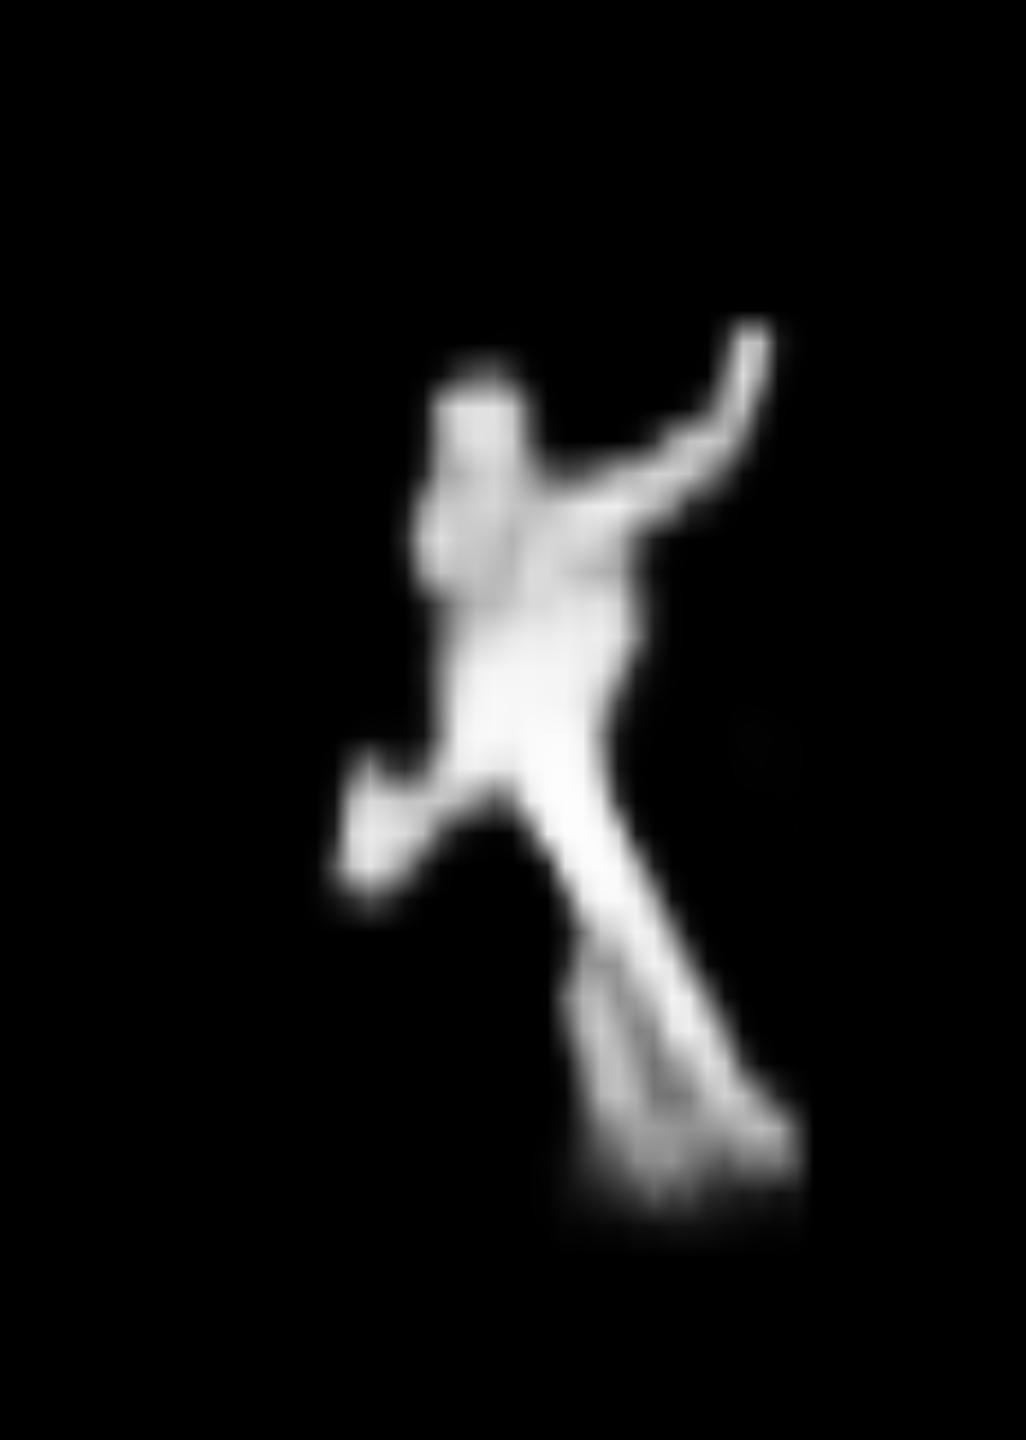

In [41]:
im1 = Image.open(io.BytesIO(base64.b64decode(b64)))
im1

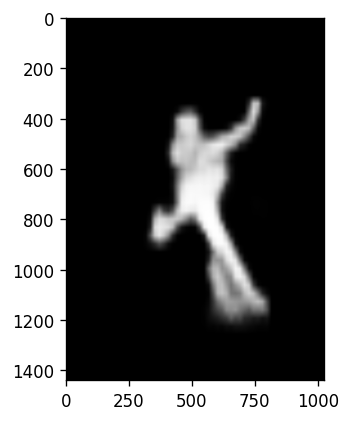

In [14]:
from skimage.transform import resize

j = 0
# plt.figure(dpi=120)
# plt.imshow(img)
plt.figure(dpi=120)
plt.imshow(mask_results[j][0][0][0], cmap='gray')
# plt.figure(dpi=120)
# plt.imshow(depth_results[j], cmap='gray')
# plt.figure(dpi=120)
# plt.imshow((bokeh_results[j][0]))

# I = np.zeros((mask[0].shape[0], mask[0].shape[1], 4))
# I[..., :3] = resize(bokeh_img[0], (mask[0].shape[0], mask[0].shape[1]))
# I[..., 3] = mask[0]
# plt.figure(dpi=120)
# plt.imshow(I)

# Image.fromarray((bokeh_img[0] * 255.).astype(np.uint8)).save(f"./res/results/{sample.stem}_bokeh_pretrain.png")